# INF589-2022-03 Index Structures


For preparation, we need to install graphviz. The following code performs the installation via pip, only if necessary, and imports the module.

In [2]:
try:
    import graphviz
except:
    %pip install graphviz
    import graphviz

## Tries and suffix trees

To make your life easier, we will use the following Tree class. It even provides a way to generate nice plots of the tree via graphviz.

In [3]:
class Tree:
    """
    N-ary tree with node and edge labels
    
    Trees can be constructed by adding children via method add_child.
    """
    def __init__(self, label=""):
        self.children = list()
        self.label = label

    def create(self,*args):
        return Tree(*args)
    
    def add_child(self, edge_label=None, label=""):
        """
        Add child
        
        Args:
            edge_label: edge label
            label: label of child node
        Returns:
            new child tree
        """
        self.children.append((edge_label, self.create(label)))
        return self.children[-1][1]

    def _add_to_graphviz(self, dot, index=1):
        """Add edges and nodes to graphviz object"""
        root = index
        dot.node(str(root), str(self.label))
        index += 1
        
        for e, c in self.children:
            child_index = index
            index = c._add_to_graphviz(dot, child_index)
            dot.edge(str(root), str(child_index), label=str(e))
        
        return index
    
    def dot(self, *, graph_attr={'rankdir': 'LR', 'ranksep': '0.4'},
            node_attr={'shape': 'plaintext', 'width': '0.1', 'height': '0.1'},
            edge_attr={'arrowsize': '0.75'}
           ):
        """
        Construct Graphviz Digraph of the tree
        
        Returns: tree as graphviz.Digraph
        """
        
        dot = graphviz.Digraph('Tree')

        dot.graph_attr.update(graph_attr)
        dot.node_attr.update(node_attr)
        dot.edge_attr.update(edge_attr) ## ,lblstyle="above, sloped" ?? with tikz

        self._add_to_graphviz(dot)
        return dot

As immediate benefit, we can construct and draw trees:

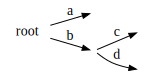

In [4]:
t = Tree("root")
c1 = t.add_child("a")
#c1.add_child("e")
c2 = t.add_child("b")
c2.add_child("c")
c2.add_child("d")

t.dot()
#t.dot(graph_attr={'ranksep': '0.2', 'nodesep': '1'},edge_attr={'color': 'blue', 'arrowsize': '0.5'})

We will first construct prefix and suffix tries. Recall that we can construct them by inserting strings one by one into a trie.

Prefix tries are usually generated for a set of given query strings, while suffix tries are generated by inserting all suffices of text (in which we want to search).

As preparation, we extend the Tree class to support insertion of strings with annotation.

In [5]:
class Trie (Tree):
    def __init__(self, label=""):
        super().__init__(label)
    
    def create(self, *args):
        return Trie(*args)
        
    def lookup_child(self, edge_label):
        """
        Lookup index of child with edge label, assume sorted children
        """
        
        for c in self.children:
            if c[0] == edge_label:
                return c[1]

        return None
                
    def add_child(self, edge_label, label=""):
        """
        Get child with edge label, keeping edge labels alphabetically sorted
        """
        
        if self.children==[] or self.children[-1][0]<edge_label:
            i = len(self.children)
        else:
            for i, c in enumerate(self.children):
                if c[0] > edge_label:
                    break
                    
        c = self.create(label)
        self.children.insert(i, (edge_label, c))
        return c
    
    def insert( self, x, annotation ):
        """
        Insert string x with annotation
        
        Args:
          x: string
          annotation: typically the word index
        
        This inserts new branches in alphabetical order
        """
        if x == "":
            self.label = annotation
            return

        c = self.lookup_child(x[0])
        if c is None:
            c = self.add_child(x[0])
            c.ol = annotation

        c.insert( x[1:], annotation)


### Assignment 1: Prefix trie construction

Complete the code of the function ```construct_trie()``` that adds all strings in a given list `words` to an initially empty trie and annotates them with their index in `words`. This should take at most a few lines (but is essential for going on.)

Note that we show below how to print the trie, such that you can test your code.

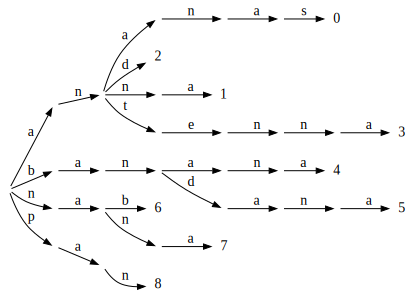

In [6]:
def construct_trie( words ):
    """
    Construct a trie from a list of words
    @param words list of strings
    @return trie containing the words, annotated with the words indices
    """
    trie = Trie()
    for i,word in enumerate(words):
        trie.insert(word,i)
    # ADD YOUR CODE HERE

    return trie

# let's define some example words
words = [ "ananas", "anna", "and", "antenna", 
          "banana", "bandana", "nab", "nana", "pan"]

# and construct a prefix trie containing these words
prefix_trie = construct_trie( words )

prefix_trie.dot()

### Assignment 2: Search using a prefix_trie

Search through a text using the prefix trie. Complete the code in function ```prefix_trie_search()```.

For the search, iteratively try to match the text to the trie starting from each position `i` of the text.

It could be convenient to first write a 'helper function' that matches a trie at one specific position `pos` to the text.


In [7]:
def prefix_trie_search( text, trie ):
    """
    Find all occurrences of multiple patterns (encoded in a trie)
    
    Args:
      text: the text
      trie: the trie
      
    Returns: list of pairs (i,k), 
        encoding the occurrences of patterns k at positions i
    """

    occurrences = list()
    
    for pos,letter in enumerate(text):
      posi=pos
      letter = text[pos]
      child_edge=trie.lookup_child(letter)
      while child_edge is not None:
        posi+=1
        if posi<len(text):
          letter = text[posi]
          child_edge=child_edge.lookup_child(letter)
          if (child_edge is not None) and child_edge.label!="":
            # print("Word:"+words[child_edge.label]+" found!")
            occurrences.append( (pos,child_edge.label) )
          # elif child_edge is None:
            # print("No word found, next letter")
        else:
          break
    return occurrences

Test your function with a few examples like the one below.
(How about trying some real DNA as well, e.g. simulated reads from Corona...?) 

In [8]:
## some test of prefix trie search
text = "bannamabananpananasbanana"
words = [ "ananas", "anna", "and", "antenna", 
          "banana", "bandana", "nab", "nana", "pan"]

prefix_trie = construct_trie(words)
occurrences = prefix_trie_search( text, prefix_trie )

for (i,k) in occurrences:
    print("{:2}: {}".format(i,words[k]))

 1: anna
12: pan
13: ananas
14: nana
19: banana
21: nana


### Assignment 3: Suffix tree construction

Construct a suffix trie by inserting all suffices of text into an originally empty tree using ```trie_insert()```.

In [9]:
def construct_suffix_trie(text):
    """
    Construct suffix trie
    @param text the text
    @returns trie of all suffixes of text
    """

    trie = Trie()
    
    # ADD YOUR CODE HERE
    ## using list comprehension, this could be a one liner of the form:
    # trie = construct_trie( [ ... for ... in ... ] )
    words=[]
    for i in range(len(text)):
        words.append(text[i:])
    trie = construct_trie(words)
    return trie

Again test the code and draw suffix tries...

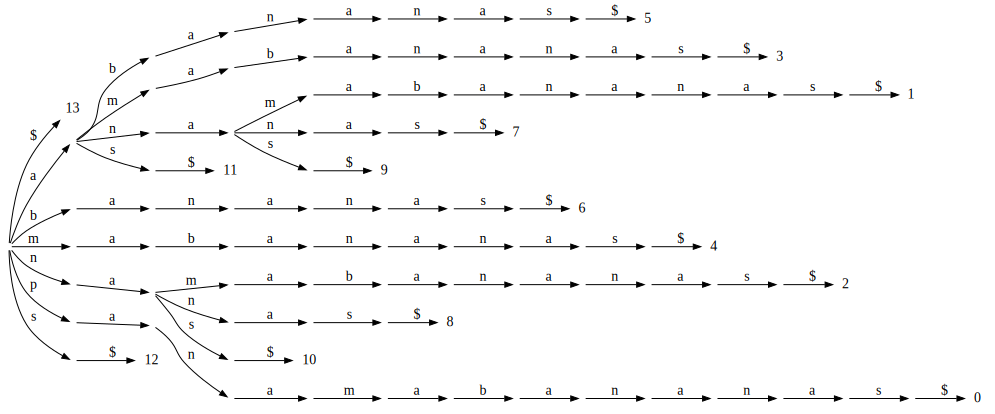

In [10]:
text = 'panamabananas$'
# text = 'ananasbanana$'
suffix_trie = construct_suffix_trie(text)

suffix_trie.dot()

One obtains the suffix tree from a suffix trie by compressing it. This is performed by the given function ```compress_trie()```.

In [11]:
## compress trie (suffix trie -> suffix tree)
import copy

def compress_trie(trie):
    """
    Compress trie
    
    Returns: compressed tree
    """
    # make a copy
    # trie = copy.deepcopy(trie)
    for i,(label,child) in enumerate(trie.children):
        compress_trie(child)
        if len(child.children) == 1:
            ## merge with child
            clabel, cchild = child.children[0]
            trie.children[i] = (label+clabel, cchild)
    # return(trie)

Use the given code to produce a suffix tree from your suffix tries. 

Btw, you are right, if you find this method for the construction of suffix trees unelegant. Indeed, this would be too wasteful in practice and there are much better (linear time and space) algorithms.

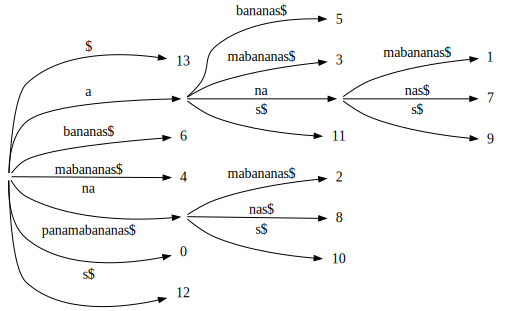

In [12]:
trie = copy.deepcopy(suffix_trie)
compress_trie(trie)
trie.dot()

### Assignment 4: Search in a suffix tree

Implement the function ```suffix_tree_search``` to search a word x in a suffix tree. Test it with a few suffix trees and words.

This assignment could be conveniently skipped, if you think that searching in SA and BWT is anyway much more interesting.

In [13]:
def suffix_tree_search( tree, x ):
    """
    Search x in a suffix tree
    Args:
      tree: a suffix tree
      x:    a word
    Result: list of all occurrences of x in the text
    """
    for (label, cchild) in tree.children:
        if x==label:
            return(True)
        elif len(x)>len(label):
            if x[:len(label)]==label:
              return(suffix_tree_search( cchild, x[len(label):] ))
        else:
            if x==label[:len(x)]:
	            return(True)
            #do it again with x[:len(label)]
            #next sequence = x[len(label):]
    return False

In [14]:
for word in words:
	print(word," in tree:",suffix_tree_search( trie, word ))

ananas  in tree: True
anna  in tree: False
and  in tree: False
antenna  in tree: False
banana  in tree: True
bandana  in tree: False
nab  in tree: False
nana  in tree: True
pan  in tree: True


## Suffix arrays and Burrows Wheeler Transform

### Assignment 5: Suffix arrays

There are many differently efficient ways to construct a suffix array; here, we don't bother with the most efficient ones. Since we already have a suffix tree (with alphabetically sorted branches), we construct one from the tree; complete the function ```construct_suffix_array()``` by harvesting the leave annotations. (This could be compared to a naive construction of the suffix array by string sorting all suffixes.)

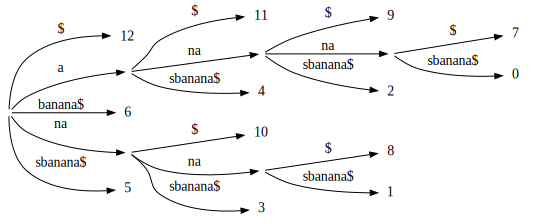

In [15]:
# text = 'panamabananas$'
text = 'ananasbanana$'
suffix_trie = construct_suffix_trie(text)
trie = copy.deepcopy(suffix_trie)
compress_trie(trie)
trie.dot()

In [16]:
trie.children

[('$', <__main__.Trie at 0x7feada7059a0>),
 ('a', <__main__.Trie at 0x7feada7051f0>),
 ('banana$', <__main__.Trie at 0x7feada87de20>),
 ('na', <__main__.Trie at 0x7feada705520>),
 ('sbanana$', <__main__.Trie at 0x7feada5e2190>)]

In [17]:
def construct_suffix_array(tree):
    """
    Construct suffix array from a (sorted) suffix tree
    @param tree the suffix tree
    @returns the suffix array (a list of integers)
    """

    ## ADD CODE HERE
    sa=list()
    for (label, child) in tree.children:
        if len(child.children) == 0:
            sa.append((label,child.label))
        else:
            sa_child=construct_suffix_array(child)
            for (label_c,child_c) in sa_child:
                sa.append((label+label_c,child_c))
    return sa

suffix_array=construct_suffix_array(trie)
suffix_array

[('$', 12),
 ('a$', 11),
 ('ana$', 9),
 ('anana$', 7),
 ('ananasbanana$', 0),
 ('anasbanana$', 2),
 ('asbanana$', 4),
 ('banana$', 6),
 ('na$', 10),
 ('nana$', 8),
 ('nanasbanana$', 1),
 ('nasbanana$', 3),
 ('sbanana$', 5)]

For completeness, here is code that searches a word in a text with the help of its suffix array. 

You'll observe that it should be possible to speed up this code using binary search. You are welcome to improve the code.

In [42]:
def suffix_array_search( text: str, sa: list, x: str )->list:
    """Search (naively) the occurences of x in text, with a suffix array

    Args:
        text (str): original text
        sa (list): suffix array, [(suffix, index)]
        x (str): word to search

    Returns:
        list: [(suffix in which the word appears, index)]
    """
    
    start = 0
    end = len(sa)

    def narrow_start(i,c):
        for j in range(start,end):
            if text[i+sa[j][1]]==c:
                return j
        return end
    
    def narrow_end(i,c):
        for j in reversed(range(start,end)):
            if text[i+sa[j][1]]==c:
                return j+1
        return start
    
    for i,c in enumerate(x):
        start = narrow_start(i,c)
        end   = narrow_end(i,c)

        if start>=end:
            return None
        
    return sa[start:end]

occurrences = suffix_array_search( text, suffix_array, "anan")
print(occurrences)

[('anana$', 7), ('ananasbanana$', 0)]


In [86]:
def suffix_array_binary_search(text, sa, x):
    """Search (with binary search) the occurences of x in text, with a suffix array

    Args:
        text (str): original text
        sa (list): suffix array, [(suffix, index)]
        x (str): word to search

    Returns:
        list: [(suffix in which the word appears, index)]
    """

    start = 0
    end = len(sa)-1

    def narrow_start(i: int, c: int, s=0, e=end):
        j = (s+e)//2
        while j<e:
            if text[i+sa[j][1]]==c:
                if j == s or text[i+sa[j-1][1]]!=c:
                    return j
                else:
                    e = j
                    j = (s+j)//2
            else:
                if j == e:
                    return end
                else:
                    if e-s==1:
                        s=e
                        j=e
                    s = j
                    j = (e+j)//2
        return end
    
    def narrow_end(i: int, c: int, s=0, e=end):
        j = (s+e)//2
        while j<e:
            if text[i+sa[j][1]]==c:
                if j == e or text[i+sa[j+1][1]]!=c:
                    return j
                else:
                    if e-s==1:
                        s=e
                        j=e
                    s = j
                    j = (e+j)//2
            else:
                if j == e:
                    return end
                else:
                    e = j
                    j = (s+j)//2
        return end

    for i,c in enumerate(x):
        start = narrow_start(i, c, s=start, e=end)
        end   = narrow_end(i, c, s=start, e=end)

        if start>end:
            return None
        
    return sa[start:end+1]

occurrences = suffix_array_binary_search( text, suffix_array, "s")
print(occurrences)

[('sbanana$', 5)]


### Assignment 6: Construction of the Burrows Wheeler Transform

The BWT of a text can be directly generated from the suffix array SA of the text. The key idea is that ```BWT[0] = text[-1]``` and ```BWT[i] = text[SA[i]-1]``` for all i>0.

Write a function ```construct_bwt()``` that takes a text, constructs its suffix array and returns the BWT of the text.

Compare this to a 'naive' BWT construction from producing all rotations of text and sorting them. Compare. Why is it (in several respects) smarter to construct the BWT from the suffix array?

In [19]:
def construct_bwt_naive( text ):
    """Construct the Burrows Wheeler transform
    @param text
    @returns BWT(text)
    """
    ## ADD CODE HERE
    n=len(text)
    sa=[]
    for i in range(n):
        sa.append(text[i:]+text[:i])
    sa.sort()
    BWT=''
    for i in range(n):
        BWT+=sa[i][-1]
    return(BWT)

def construct_bwt( text ):
    """Construct the Burrows Wheeler transform
    @param text
    @returns BWT(text)
    """
    ## ADD CODE HERE
    n=len(text)
    suffix_trie = construct_suffix_trie(text)
    trie = copy.deepcopy(suffix_trie)
    compress_trie(trie)
    sa=construct_suffix_array(trie)
    BWT=''
    for i in range(n):
        BWT+=text[sa[i][1]-1]
    return(BWT)

text = 'ananasbanana$'
print(construct_bwt_naive( text ))
print(construct_bwt( text ))

annb$nnsaaaaa
annb$nnsaaaaa


### Assignment 7: Search in BWT

Write a function that identifies all occurences of pattern ```x``` in a text making clever use of its BWT. Your algorithm should keep two pointers 'start' and 'end' that represent the first and last+1 index of your search range in the BWT. Initially these two indices are 0 and len(bwt) respectively. For each character of the pattern (from right to left), one can narrow down the search range.
In the end, the range corresponds to the occurrences of the pattern. This algorithm resembles the example for BWT-supported pattern search shown on the lecture slides.

Your algorithm should make use of a mapping $\operatorname{ltf}(i)$ ("last to first"), such that the last character of row $i$ corresponds to the first character of row $\operatorname{ltf}(i)$. $\operatorname{ltf}(i)$ should be precomputed and stored in an array; note that the mapping is unique due to the order-preserving "first-last" property of the BW-transformation. 

To test your algorithm, compare to the search results using suffix trees or suffix arrays.

Your search function could look like:

In [37]:
"123456789"[::8]

'19'

In [21]:
def bwt_search( bwt_index, x ):
    """
    Search pattern x in BWT
    
    Args:
        bwt_index: BWT-index containing bwt and potentially additional
        pre-computed tables
        x: pattern
    Returns:
        occurrences of x in the indexed text
    """
    start = 0
    end = len(bwt_index)
    
    ltf
    for i,c in enumerate(x[::-1]):
        start = narrow_start(i,c)
    end   = narrow_end(i,c)

    if start>=end:
        return None


    ## ADD CODE HERE
    return(0)
    
def suffix_array_search( text, sa, x ):
    
    start = 0
    end = len(sa)

    def narrow_start(i,c):
        for j in range(start,end):
            if text[i+sa[j][1]]==c:
                return j
        return end
    
    def narrow_end(i,c):
        for j in reversed(range(start,end)):
            if text[i+sa[j][1]]==c:
                return j+1
        return start
    
    for i,c in enumerate(x):
        start = narrow_start(i,c)
        end   = narrow_end(i,c)

        if start>=end:
            return None
        
    return sa[start:end]

If time allows, look into different ways to improve the search using a BWT index.

* Precompute the first occurrence of each character in the first column. Does it save work in your search? 
* Use the suffix array to return the occurrences of the pattern (instead of only the number of occurrences).
* Compute count tables and make use of binary search in the count tables to speed up the search.

If you make improvements, keep the old version. Can you show a performance difference between the versions (on sufficiently large data)?